

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Lunar Lander**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the lunar lander problem (see [Lunar Lander documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)).


AUTHORS:
- Eder Tarifa
- Adonis García
- Mario García

Para ejecutar el notebook hemos utilizado la CPU de Google Colab.

## Hyperparameters

In [ ]:
GAMMA = 0.99
MEMORY_SIZE = 50000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.95
MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
NUMBER_OF_EPISODES_FOR_TESTING = 30
GOAL_SCORE = 200
NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE = 30
LEARN_BATCH = 30

CHANGES IN THE ALGORITHM:

We have implemented three major changes to the algorithm to both reduce training time and achieve better results.

1. First, we modified the memory code to allow for a smaller memory size. Now, when the memory fills up, it overwrites the oldest data instead of simply reaching capacity. This change offers two main advantages: it enables us to reduce memory size and increases the algorithm’s speed, as it overwrites information from early iterations (when the neural networks were not yet trained) with information from later iterations (when the networks are expected to predict more reliably).

2. Second, we modified our neural network, now consisting of two hidden layers, and created a second network identical to the first, which is responsible for predicting outputs in the learning function. This change aims to reduce learning time by providing greater stability, as this second network does not learn in every iteration, leading to more stable predictions that the first network can then use for learning. Without this adjustment, the network struggles to converge to a solution, as it would otherwise learn based on predictions made with weights that change at every iteration.

3. Complementing the previous change, and to make it effective, we modified the code by adding a new hyperparameter named LEARN_BATCH. This parameter represents the number of transitions that must pass before the weights of the second neural network are updated with the weights from the first.

To run the notebook, we used the Google Colab CPU.

## Class ReplayMemory

Memory of transitions for experience replay.

In [ ]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size % MEMORY_SIZE
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [ ]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Neural model
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(24, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(120, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(120, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # Neural model target
        self.model_target = keras.models.Sequential()
        self.model_target.add(keras.layers.Dense(24, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(120, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(120, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model_target.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # self.model_target.set_weights(self.model.get_weights)

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model(state).numpy()
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        state = np.reshape(state, [1, self.number_of_observations])
        q_values = self.model(state).numpy()
        return np.argmax(q_values[0])

    def learn(self, learn : bool):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model_target(states).numpy()
        q_next_states = self.model_target(next_states).numpy()

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

        if learn:
          # print("Weights has been updated")
          weights = self.model.get_weights()
          self.model_target.set_weights(weights)

    def add_score(self, score):
        # Add the obtained score to a list to be presented later
        self.scores.append(score)

    def delete_scores(self):
        # Delete the scores
        self.scores = []

    def average_score(self, number_of_episodes):
        # Compute average score of the last episodes
        index = len(agent.scores) - number_of_episodes
        return np.mean(self.scores[max(0,index):(len(agent.scores))])

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Environment Lunar Lander

---

<img height="200px" src="https://gymnasium.farama.org/_images/lunar_lander.gif" align="center" vspace="20px">

State vector:
- state[0]: lander x coordinate
- state[1]: lander y coordinate
- state[2]: lander x linear velocity
- state[3]: lander y linear velocity
- state[4]: lander x angular velocity
- state[5]: lander y angular velocity
- state[6]: lander leg connected to ground
- state[7]: lander other leg connected to ground

Actions:
- 0 (do nothing)
- 1 (fire left orientation engine)
- 2 (fire main engine)
- 3 (fire right orientation engine)

In [ ]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Program for training




Episode   1: score -11 (exploration rate: 1.000, average score: -11, transitions: 114)
Episode   2: score -358 (exploration rate: 0.950, average score: -185, transitions: 227)
Episode   3: score -147 (exploration rate: 0.902, average score: -172, transitions: 358)
Episode   4: score -174 (exploration rate: 0.857, average score: -173, transitions: 438)
Episode   5: score -234 (exploration rate: 0.815, average score: -185, transitions: 536)
Episode   6: score -89 (exploration rate: 0.774, average score: -169, transitions: 624)
Episode   7: score -285 (exploration rate: 0.735, average score: -186, transitions: 756)
Episode   8: score -265 (exploration rate: 0.698, average score: -196, transitions: 891)
Episode   9: score -188 (exploration rate: 0.663, average score: -195, transitions: 1016)
Episode  10: score -111 (exploration rate: 0.630, average score: -187, transitions: 1143)
Episode  11: score -190 (exploration rate: 0.599, average score: -187, transitions: 1275)
Episode  12: score -1

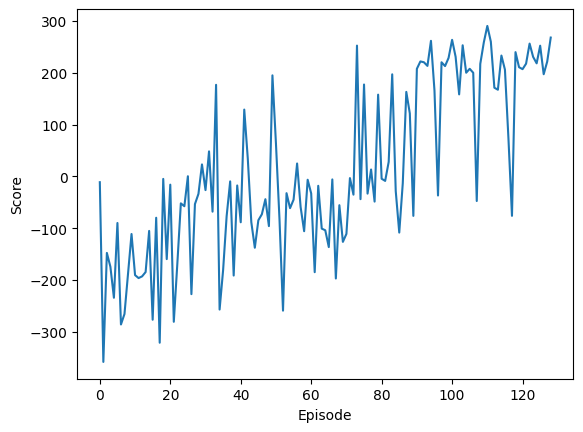

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
start_time = time.perf_counter()
total_steps = 1
exploration_rate = EXPLORATION_MAX
goal_reached = False
learn_batch = 0
while (episode < MAX_NUMBER_OF_EPISODES_FOR_TRAINING) and not(goal_reached):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        learn_batch +=1
        # Select an action for the current state
        action = agent.select(state, exploration_rate)

        # Execute the action on the environment
        state_next, reward, terminal_state, truncated, info = environment.step(555)

        # Store in memory the transition (s,a,r,s')
        agent.remember(state, action, reward, state_next, terminal_state)

        score += reward

        # Learn using a batch of experience stored in memory
        if learn_batch == LEARN_BATCH:
          agent.learn(True)
          learn_batch = 0
        else:
          agent.learn(False)

        # Detect end of episode
        if terminal_state or truncated:
            end_episode = True
            agent.add_score(score)
            average_score = agent.average_score(NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE)
            if average_score >= GOAL_SCORE: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(math.trunc(score)), end = '')
            print("(exploration rate: %.3f, " % exploration_rate, end = '')
            print("average score: {0:>3}, ".format(round(average_score)), end = '')
            print("transitions: " + str(agent.memory.current_size) + ")")
        else:
            state = state_next
            total_steps += 1

    # Decrease exploration rate
    exploration_rate *= EXPLORATION_DECAY
    exploration_rate = max(EXPLORATION_MIN, exploration_rate)

print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average last episodes):", round(average_score))
print("Score (max):", round(max(agent.scores)))

agent.display_scores_graphically()


## Program for testing



In [ ]:
agent.delete_scores()
episode = 0
start_time = time.perf_counter()
while (episode < NUMBER_OF_EPISODES_FOR_TESTING):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        # Select an action for the current state
        action = agent.select_greedy_policy(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        score += reward

        # Detect end of episode and print
        if terminal_state or truncated:
            agent.add_score(score)
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} \n".format(round(score)), end = '')
            end_episode = True
        else:
            state = state_next

print("Time for testing:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average):", round(np.mean(agent.scores)))
print("Score (max):", round(max(agent.scores)))

Episode   1: score 242 
Episode   2: score 281 
Episode   3: score 222 
Episode   4: score 216 
Episode   5: score 256 
Episode   6: score 175 
Episode   7: score  88 
Episode   8: score 238 
Episode   9: score 185 
Episode  10: score 228 
Episode  11: score 207 
Episode  12: score 234 
Episode  13: score 245 
Episode  14: score 223 
Episode  15: score 239 
Episode  16: score 279 
Episode  17: score 237 
Episode  18: score 240 
Episode  19: score 248 
Episode  20: score 238 
Episode  21: score 171 
Episode  22: score 277 
Episode  23: score 227 
Episode  24: score 109 
Episode  25: score 148 
Episode  26: score 204 
Episode  27: score 227 
Episode  28: score 194 
Episode  29: score 225 
Episode  30: score 236 
Time for testing: 0 minutes
Score (average): 218
Score (max): 281


## Pruebas realizadas
---
We have kept the following hyperparameters constant:
- EXPLORATION_MAX = 1
- MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
- NUMBER_OF_EPISODES_FOR_TESTING = 30
- GOAL_SCORE = 200
- NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE = 30


Discount Factor | Memory Size | Learning Rate | Batch Size | Exploration Min | Exploration Decay | Learn Batch | Observations
--------------- | ----------- | ------------- | ---------- | --------------- | ----------------- | ----------- | ------------
0.99            | 200000      | 0.01          | 64         | 0.01            | 0.96              | -           | Before implementing the learn batch for the second neural network and the memory change, we ran several tests. In this case, our model did not learn; all results were negative even after training for over an hour. We had to increase the memory size from 100000 (the default in Cartpole) to 200000 to prevent errors from memory overflow.
0.99            | 200000      | 0.005         | 64         | 0.01            | 0.9               | -           | We decided to reduce the learning rate and decrease exploration decay to make the model less exploratory. This resulted in even worse performance than before.
0.99            | 200000      | 0.005         | 64         | 0.3             | 0.9               | -           | To maintain a minimum level of exploration, we increased the exploration min, but the results were still poor. As this approach was not yielding good results, we decided to change our strategy.
0.99            | 100000      | 0.0005        | 32         | 0.001           | 0.95              | 10          | We implemented the learn batch as explained at the beginning of the notebook, updating the model every 10 transitions. However, the learning rate was too high, and frequent weight updates made convergence challenging.
0.99            | 100000      | 0.0002        | 64         | 0.01            | 0.96              | 4           | We used the learn batch mechanism to update the model every 4 transitions, allowing us to reduce memory size to 100000. The model learned successfully, although slowly, taking around 1 hour, showing a marked improvement over previous models.
0.99            | 100000      | 0.0005        | 32         | 0.001           | 0.95              | 100         | We increased the iterations needed for target network weight updates while slightly increasing the learning rate to speed up training and convergence. The model was successfully trained in approximately 30 minutes.
0.99            | 100000      | 0.0001        | 64         | 0.01            | 0.96              | 4           | We adjusted the learning rate to reduce training time, testing values like 0.00025 and 0.0005, and found the best results with 0.0001, achieving the target in about 40 minutes.
0.99            | 100000      | 0.0001        | 64         | 0.01            | 0.96              | 32          | To improve our results, we increased the batch size and learn batch to reduce learning frequency. We tested batch sizes of 128 and 264 and a learn batch of 64, but these values led to unstable oscillations in the final graph. The best results were obtained with 64 and 32, respectively.
0.99            | 100000      | 0.0001        | 64         | 0.01            | 0.95              | 32          | We reduced the exploration decay to make the model more exploratory. With a slight adjustment to 0.95, we observed improved performance. We kept the exploration min the same, as maintaining a minimum level of exploration proved beneficial.
0.99            | 50000       | 0.0001        | 64         | 0.01            | 0.95              | 32          | Finally, we made a crucial change to memory size as explained at the beginning of the notebook. This memory update significantly improved the model's performance.
```
